# Problem Statement

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution that can evaluate images and alert dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

**Step 1. Adding all necessary imports**

In [5]:
#import the required libraries
import pathlib
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout,BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.preprocessing.image import load_img

**Step 2. Importing train and test data**

In [6]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
#unzip the dataset
!unzip "/content/gdrive/MyDrive/modalImages/data/SkinCancerISICDataset.zip" > /dev/null

In [8]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")


**Step 3. Understanding the data**

In [9]:
# Count the number of images in Train and Test directory
# Using the glob to retrieve files/pathnames matching a specified pattern.

#Train Image count
img_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(img_count_train)

#Test Image count
img_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(img_count_test)

2239
118


**Step 4. Dataset creation**

Creating train & validation dataset from the train directory with a batch size of 32. Also, make sure you resize your images to 180*180.

In [10]:
# defining the batch size
batch_size = 32
img_height = 180
img_width = 180


Creating the training data(80%) and validation data(20%)

In [11]:

## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [12]:
## Write your validation dataset here
## using seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split=0.2,
  subset="validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [13]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
skin_cancer_class_names = train_ds.class_names
print(skin_cancer_class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


**Step 5. Dataset Visualisation**

In [14]:
#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in skin_cancer_class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))

In [15]:
#function to visualise all images
def visual_training_data():
  plt.figure(figsize=(15,15))
  index = 0
  for c in skin_cancer_class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")

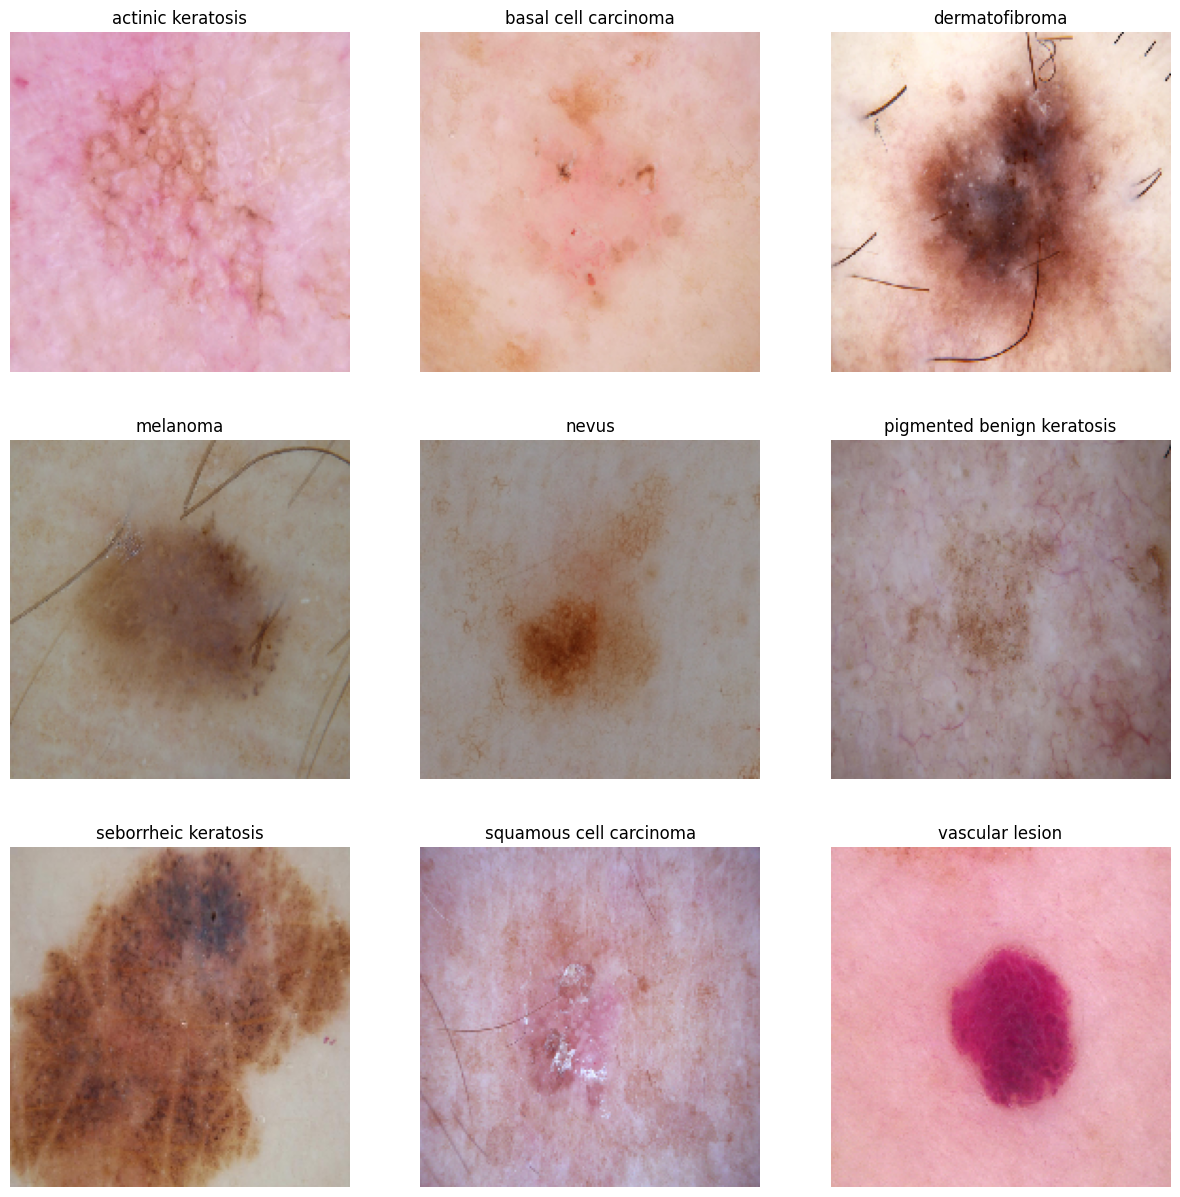

In [16]:
visual_training_data()

**Observation:-** The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Let's visualise the distribution of this data

In [17]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df


,Class,No. of Image
0,actinic keratosis,114
1,dermatofibroma,95
2,seborrheic keratosis,77
3,vascular lesion,139
4,nevus,357
5,melanoma,438
6,pigmented benign keratosis,462
7,squamous cell carcinoma,181
8,basal cell carcinoma,376


<Axes: xlabel='No. of Image', ylabel='Class'>

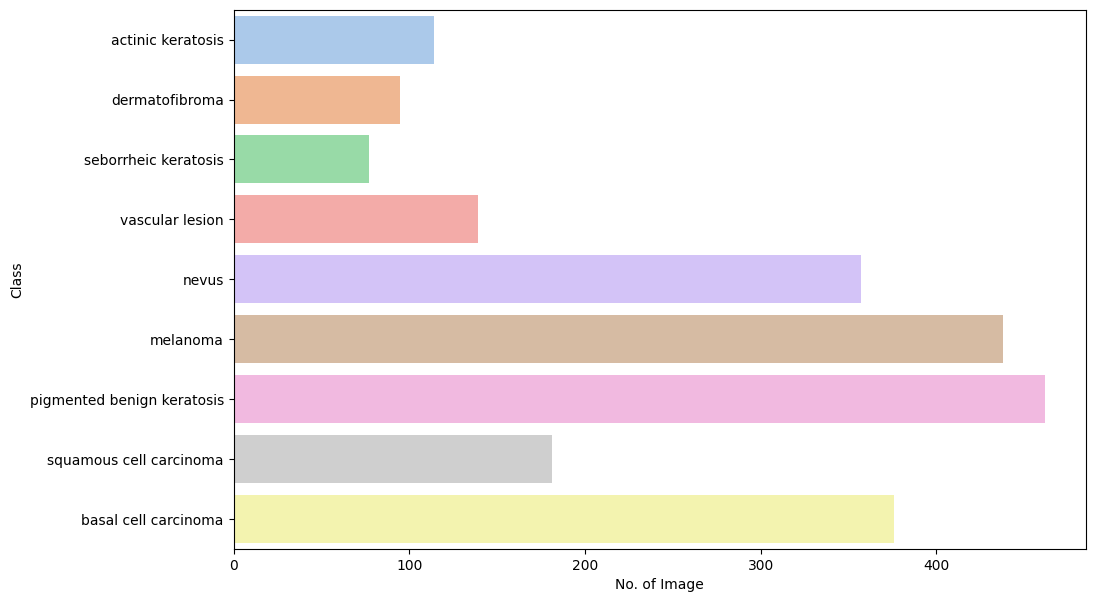

In [18]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(11, 7))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class" , palette="pastel")


**Observation :- there is a class imbalance in these set of images**

**Step 6: Creating the modal**

**pre-processing**

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

In [19]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Creating a CNN model, which can accurately detect 9 classes present in the dataset. Use layers.experimental.preprocessing.Rescaling to normalize pixel values between (0,1). The RGB channel values are in the [0, 255] range. This is not ideal for a neural network. Here, it is good to standardize values to be in the [0, 1]

**Proposed CNN Architechture**

In [20]:
#CNN Model Architecture

#Sequential allows you to create models layer-by-layer
model = Sequential()
#Rescaling Layer
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
#First Convulation layer
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
# adding dropouts
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))



In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

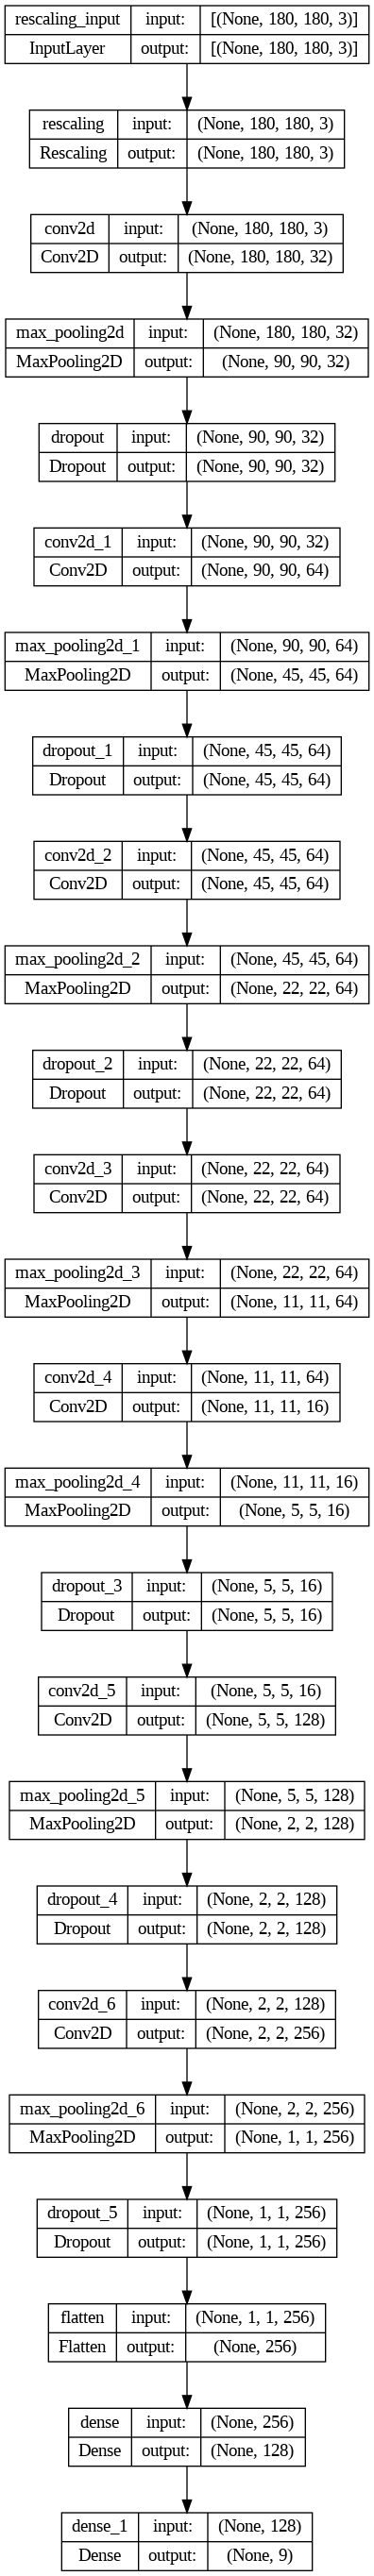

In [22]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

**Compile the modal**

Choosing an appropriate optimiser and the loss function

Adam optimization: is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.


SparseCategoricalCrossentropy: Used as a loss function for multi-class classification model where there are two or more output labels.

In [23]:

#ModelCheckpoint callback is used in conjunction with training using model.fit() to save a model or weights (in a checkpoint file) at some interval,
#so the model or weights can be loaded later to continue the training from the state saved.
#checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)

#Stop training when a monitored metric has stopped improving.
#earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1)
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [24]:
# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs,callbacks=[learn_control])

Epoch 1/20
56/56 [==============================] - 31s 115ms/step - loss: 2.0654 - accuracy: 0.1998 - val_loss: 2.0870 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0366 - accuracy: 0.1953 - val_loss: 2.0331 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 57ms/step - loss: 2.0076 - accuracy: 0.2076 - val_loss: 1.9507 - val_accuracy: 0.1588 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.9005 - accuracy: 0.2746 - val_loss: 1.8030 - val_accuracy: 0.3087 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 58ms/step - loss: 1.7532 - accuracy: 0.3499 - val_loss: 1.7504 - val_accuracy: 0.3132 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 3s 57ms/step - loss: 1.7516 - accuracy: 0.3393 - val_loss: 1.6749 - val_accuracy: 0.3647 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 56ms/step - loss: 1

**Visualizing training results**

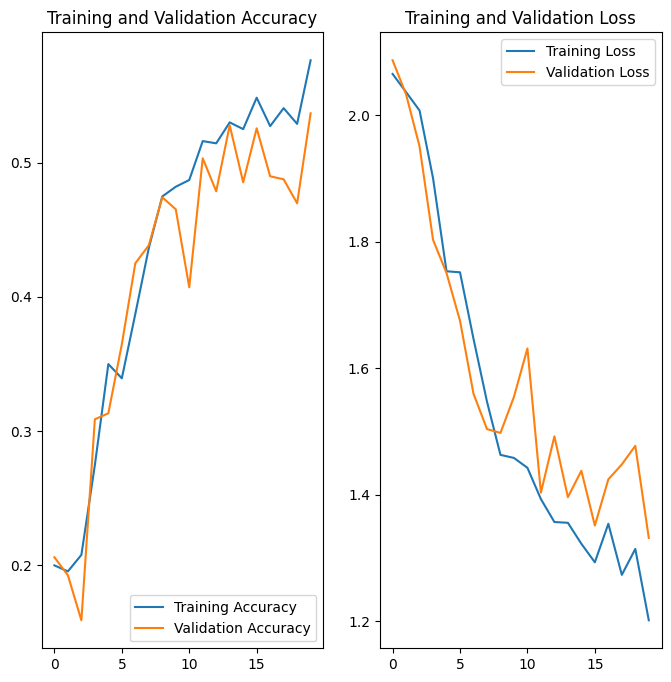

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**



1.   Training accuracy and validation accuracy curves don't overfit but  accuracy is low
2.   The graphs and accurqacy values indicate underfitting of data.
3.  Training loss has reduced in epochs.
4. Validation loss has reduced in epochs but it fluctuates .

**The modal needs to be improved through other methods like augmentation etc.We have observed class imablance on this dataset.**



In [26]:
#using custom augmentation strategy
datagen = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

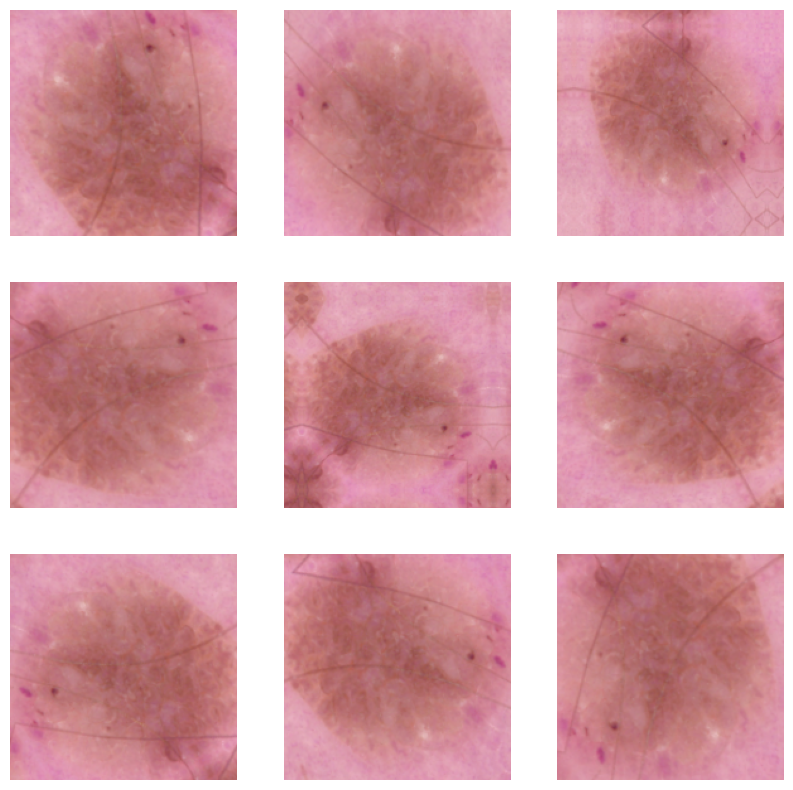

In [27]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = datagen(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

**Creating the modal after custom augmentation**

In [28]:
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(datagen) #adding augmentation
model.add(Conv2D(32, kernel_size=(3, 3),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = 'Same',activation= 'relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = 'Same',activation ='relu'))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dense(9,activation='softmax'))

**Compiling the modal**

In [29]:
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [30]:
# View the summary of all layers
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 90, 90, 32)        0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 90, 90, 64)        18496     
                                                      

In [31]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control]
)

Epoch 1/20
56/56 [==============================] - 6s 65ms/step - loss: 2.0694 - accuracy: 0.2020 - val_loss: 2.0645 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 4s 66ms/step - loss: 2.0292 - accuracy: 0.1970 - val_loss: 2.0351 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 3s 62ms/step - loss: 2.0176 - accuracy: 0.2121 - val_loss: 1.9948 - val_accuracy: 0.2416 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 3s 61ms/step - loss: 1.9394 - accuracy: 0.2656 - val_loss: 1.8941 - val_accuracy: 0.2819 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 3s 59ms/step - loss: 1.8476 - accuracy: 0.2829 - val_loss: 1.7340 - val_accuracy: 0.3110 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 4s 64ms/step - loss: 1.6937 - accuracy: 0.3605 - val_loss: 1.6619 - val_accuracy: 0.4004 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 3s 61ms/step - loss: 1.7

**Visualising the data**

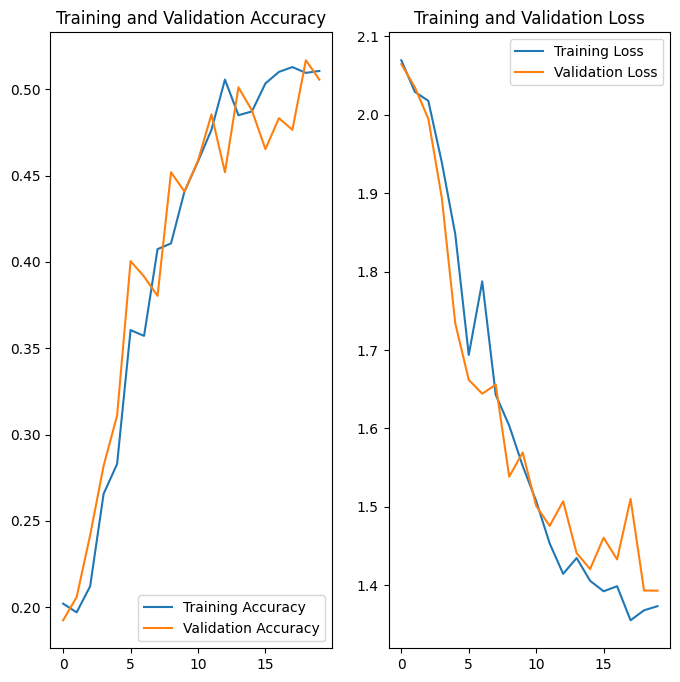

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Findings**



1.   Custom augmentation gives slightly better fit for training and validation accuracy.
2.   The accuracy is still low .
3. Class imbalance is causing issues in achieving satisfactory accuracy.



**We noticed class imbalance previously .This was plotted to show the difference. We will use Augmentor library to correct this . Also we will add augmentation properties to library**

In [33]:
#install Augmentor
!pip install Augmentor

In [34]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in skin_cancer_class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)  #Adding 500 samples per class to make sure that none of the classes are sparse


Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B901B604970>: 100%|██████████| 500/500 [00:16<00:00, 31.08 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B902B8B7D00>: 100%|██████████| 500/500 [00:18<00:00, 26.76 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B902B982F80>: 100%|██████████| 500/500 [00:20<00:00, 24.53 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B90C6DA6F20>: 100%|██████████| 500/500 [01:40<00:00,  4.99 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=1504x1129 at 0x7B90C524CBE0>: 100%|██████████| 500/500 [01:13<00:00,  6.84 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B90D073D240>: 100%|██████████| 500/500 [00:16<00:00, 30.36 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B902A13C400>: 100%|██████████| 500/500 [00:37<00:00, 13.47 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B902B89C820>: 100%|██████████| 500/500 [00:15<00:00, 31.93 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B914ACFD000>: 100%|██████████| 500/500 [00:16<00:00, 30.75 Samples/s]


In [35]:
#Count total number of image generated by Augmentor.
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


**Building Modal with Augmentor Library**

In [36]:
# train dataset
train_aug_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=32,
                                                               image_size=(180,180), label_mode='categorical',
                                                               seed=123,subset="training",
                                                               validation_split=0.2)

#label_mode is categorial, the labels are a float32 tensor of shape (batch_size, num_classes),
#representing a one-hot encoding of the class index.

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [37]:
# validation dataset
val_aug_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=32,
                                                            image_size=(180,180), label_mode='categorical',
                                                            seed=123,subset="validation",
                                                            validation_split=0.2)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [38]:
for i in skin_cancer_class_names:
    directory ='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/'
    directory_out ='/content/Skin cancer ISIC The International Skin Imaging Collaboration/Out/Train'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'*/output/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 500 samples.
basal cell carcinoma has 500 samples.
dermatofibroma has 500 samples.
melanoma has 500 samples.
nevus has 500 samples.
pigmented benign keratosis has 500 samples.
seborrheic keratosis has 500 samples.
squamous cell carcinoma has 500 samples.
vascular lesion has 500 samples.


**Observation:- All samples are 500 now.**

In [39]:
#`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

#`Dataset.prefetch()` overlaps data preprocessing and model execution while training.


AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [40]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(skin_cancer_class_names),activation='softmax'))

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_14 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 41, 41, 128)      

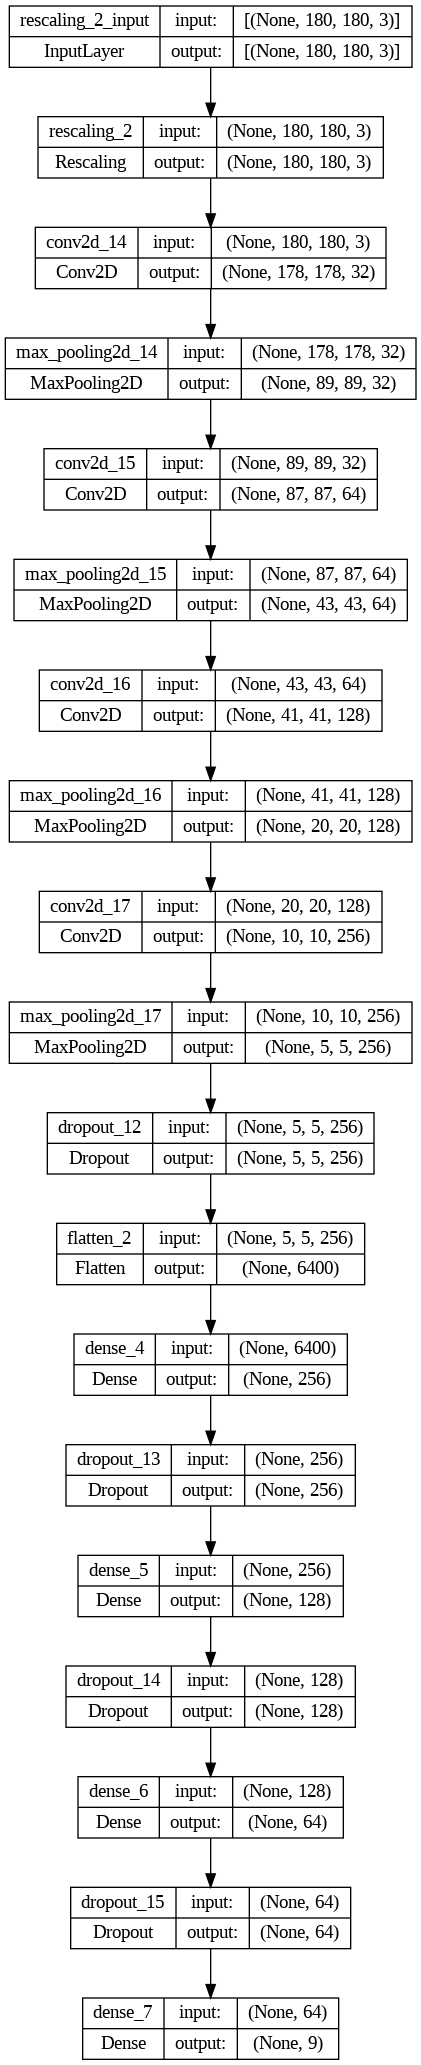

In [42]:
# vizualizing the model
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [43]:
#choose an appropirate optimiser and loss function - Adam optimiser
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer="Adam",loss="categorical_crossentropy",metrics=["accuracy"])

**Training above modal**

In [44]:
epochs = 30
history = model.fit(
  train_aug_ds,
  validation_data=val_aug_ds,
  epochs=epochs,
  callbacks=[learn_control]
)

Epoch 1/30
169/169 [==============================] - 57s 314ms/step - loss: 2.0518 - accuracy: 0.1847 - val_loss: 1.8773 - val_accuracy: 0.2405 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - 28s 158ms/step - loss: 1.8554 - accuracy: 0.2576 - val_loss: 1.7835 - val_accuracy: 0.3192 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - 29s 170ms/step - loss: 1.7024 - accuracy: 0.3366 - val_loss: 1.5835 - val_accuracy: 0.3764 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - 31s 178ms/step - loss: 1.5851 - accuracy: 0.3839 - val_loss: 1.4630 - val_accuracy: 0.4202 - lr: 0.0010
Epoch 5/30
169/169 [==============================] - 33s 191ms/step - loss: 1.5389 - accuracy: 0.3976 - val_loss: 1.3780 - val_accuracy: 0.4640 - lr: 0.0010
Epoch 6/30
169/169 [==============================] - 30s 171ms/step - loss: 1.5037 - accuracy: 0.4132 - val_loss: 1.3993 - val_accuracy: 0.4417 - lr: 0.0010
Epoch 7/30
169/169 [==============================] 

**Visualising the results**

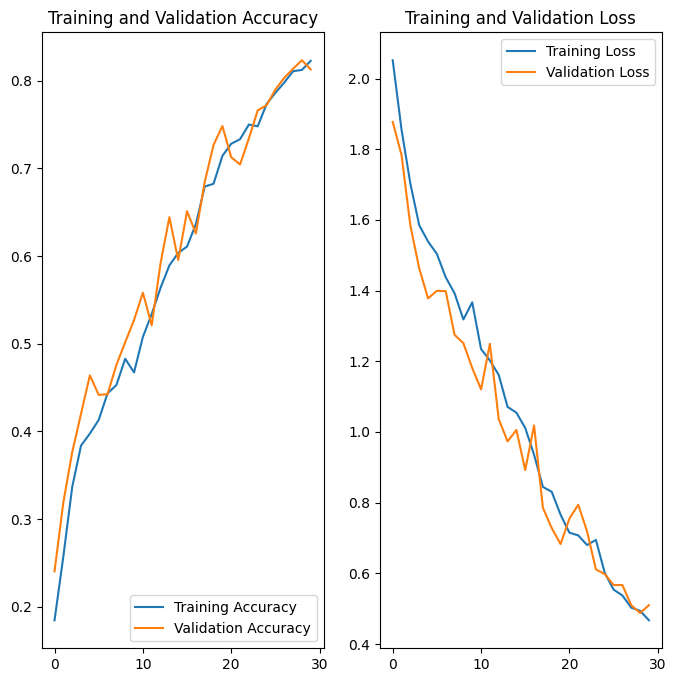

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


**Findings**

The training accuracy and validation accuracy are almost same. This is a sign of good fit.
The training loss and validation loss are almost same. This is a sign of good fit.
The Validation accuracy is 0.8129 which is good. The model is able to classify the images with 83% accuracy.

**Model Prediction on test data**

1/1 [==============================] - 0s 329ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


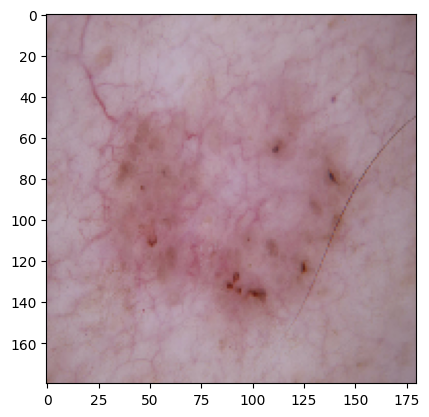

In [46]:
from glob import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, skin_cancer_class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)

img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = skin_cancer_class_names[pred]
print(f"Actual Class: {skin_cancer_class_names[1]}" + '\n' + "Predictive Class: " + pred_class)